In [4]:
import numpy as np
from matplotlib import pyplot as plt
import csv

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


plt.style.use("ggplot")

In [5]:
def plot_samples(X, y):
    fig, ax = plt.subplots()
    ax.scatter(X, y, s=4, label="Samples")
    ax.set_xlabel("X")
    ax.set_ylabel("y")

    fig.tight_layout()

    plt.show()

In [6]:
def plot_samples_and_poly_predictions(X, y, model, n):
    """
    This function plots X and y predictions of a model in the range indicated by
    X and y (X must be 1-D) of a given linear scikit learn model. The X values for
    plotting the model predictions are extended to polynomial features of 
    degree n in descending order (x^n, x^(n-1), ...)
    """

    fig, ax = plt.subplots()
    ax.scatter(X, y, s=4, label="Samples")

    X_pred = np.linspace(np.min(X), np.max(X), 100)
    X_pred_poly = np.vander(X_pred, N=n+1)

    y_plot = model.predict(X_pred_poly)

    ax.plot(
        X_pred,
        y_plot,
        linewidth=2,
        label="Model",
    )
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.legend()
    
    fig.tight_layout()

    plt.show()

In [7]:
def plot_regularization_path(alphas, mean_val_losses, mean_train_losses):
    """Plots a regularization path given alphas (regularization parameters)
    and the corresponding mean validation losses and mean training losses"""
    
    fig, ax = plt.subplots()
    ax.plot(alphas, mean_val_losses, label="Validation loss")
    ax.plot(alphas, mean_train_losses, label="Train loss")
    ax.set_xscale("log")
    ax.invert_xaxis()
    ax.set_xlabel("Regularization parameter / alpha")
    ax.set_ylabel("Loss / mean squared error")
    ax.legend()

    plt.show()

In [8]:
def load_dataset_csv(data_path):
    """Reads from a csv file assuming two columns (2D) representing X and y
    of a regression problem."""
    with open(data_path, newline='') as f:
        csv_reader = csv.reader(f)    

        next(csv_reader)

        X = []
        y = []

        for row in csv_reader:
            X.append(row[0])
            y.append(row[1])
        
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    return X, y

In [9]:
def kfold_crossval(regressor, X_design, y, k=10):
    """Function to evaluate a scikit learn model in 10-fold shuffled
    split cross validation. 
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_losses = []
    train_losses = []

    for train_index, val_index in kf.split(X_design):
        # Aufteilen der Daten in Trainings- und Validierungsdaten
        X_train, X_val = X_design[train_index], X_design[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fitten des Modells auf die Trainingsdaten
        regressor.fit(X_train, y_train)

        # Vorhersagen für Trainings- und Validierungsdaten
        y_train_pred = regressor.predict(X_train)
        y_val_pred = regressor.predict(X_val)

        # Berechnen der Mean Squared Errors
        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_val, y_val_pred)

        # Fehler sammeln
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Durchschnittliche Fehler berechnen
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)

    return mean_val_loss, mean_train_loss


In [10]:
def regularization_path(X_design, y, alphas):
    """Samples a regularization path given X, y and alphas (regularization
    parameters) for a linear, l2 regularized model.""" 

    mean_val_losses = []
    mean_train_losses = []

    # Für jeden Regularisierungsparameter Alpha den k-fold Cross-Validation-Fehler berechnen
    for alpha in alphas:
        # Erstellen eines Ridge-Regressors mit dem aktuellen Alpha-Wert
        regressor = Ridge(alpha=alpha)
        
        # Berechnung der mittleren Validierungs- und Trainingsfehler mittels kfold_crossval
        mean_val_loss, mean_train_loss = kfold_crossval(regressor, X_design, y)
        
        # Fehler in den Listen speichern
        mean_val_losses.append(mean_val_loss)
        mean_train_losses.append(mean_train_loss)

    return mean_val_losses, mean_train_losses

In [11]:
def best_regularization_parameter(alphas, mean_val_losses, mean_train_losses):
    """Finds the regularization parameter with the smallest validation loss given alphas (regularization parameters)
    and the corresponding mean validation losses and mean training losses"""

    best_index = np.argmin(mean_val_losses)

    # Bester Alpha-Wert und die entsprechenden Fehler
    best_alpha = alphas[best_index]
    best_alpha_val_loss = mean_val_losses[best_index]
    best_alpha_train_loss = mean_train_losses[best_index]

    return best_alpha, best_alpha_val_loss, best_alpha_train_loss

./regularization_dataset0.csv:


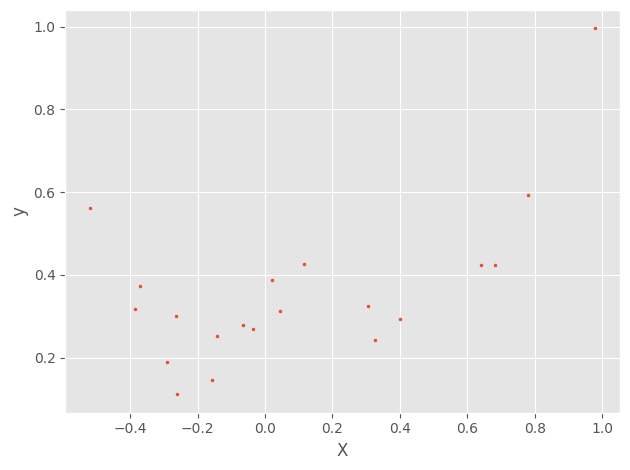

TypeError: regularization_path() got an unexpected keyword argument 'X'

In [13]:
datasets = {f"./regularization_dataset{i}.csv": load_dataset_csv(f"./regularization_dataset{i}.csv") for i in range(2)}

# Iteration über die Datensätze
for name, (X, y) in datasets.items():
    print(f"{name}:")
    plot_samples(X, y)
    
    # Festlegen der Regularisierungsparameter und des Polynomialgrads
    alphas = np.logspace(-4, 4, 10)  # Wertebereich für die Regularisierungsparameter (von 10^-4 bis 10^4)
    poly_degree = 8  # Polynomialgrad gemäß Angabe auf dem Aufgabenblatt

    # Sicherstellen, dass X die richtige Form hat
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Erstellen der Designmatrix für Polynomialregression
    poly = PolynomialFeatures(degree=poly_degree)
    X_poly = poly.fit_transform(X)


    # Berechnen der mittleren Fehler mit dem Regularisierungspfad
    mean_val_losses, mean_train_losses = regularization_path(X=X_poly, y=y, alphas=alphas)
    plot_regularization_path(alphas, mean_val_losses, mean_train_losses)

    # Finden des besten Regularisierungsparameters
    best_alpha, best_alpha_val_loss, best_alpha_train_loss = best_regularization_parameter(alphas, mean_val_losses, mean_train_losses)
    print("Best validation error:", best_alpha_val_loss)
    print("Corresponding train error:", best_alpha_train_loss)
    print("Corresponding alpha:", best_alpha)

    # Fitten eines Modells mit dem besten Alpha-Wert
    best_model = Ridge(alpha=best_alpha)
    best_model.fit(X_poly, y)

    # Plotten der Stichproben und der Polynomial-Vorhersagen
    plot_samples_and_poly_predictions(X=X, y=y, model=best_model, n=poly_degree)